In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import necessary moldules/packages

In [ ]:
import pandas as pd
import os
import numpy as np
import re
import json

## Preprocess CELLS dataset



In [ ]:
def read_txt(path):
    f = open(path, 'r')
    content = f.readlines()
    return content

In [ ]:
def get_paragraphs_pls_data(prefix, data_dir ="gdrive/MyDrive/thesis_data/CELLS/"):

  source_name = prefix+'.source'
  target_name = prefix+'.target'

  src_path = data_dir + source_name
  tgt_path = data_dir + target_name
  tgt_txt, src_txt = read_txt(tgt_path), read_txt(src_path)
  tgt_txt = [i.strip() for i in tgt_txt]
  src_txt = [i.strip() for i in src_txt]

  print("Number of abstracts of scientific " + str(prefix) + " dataset: " + str(len(tgt_txt)))
  print("Number of abstracts of plain " + str(prefix) + " dataset: " + str(len(src_txt)))

  # assign labels
  df = pd.DataFrame(data=(tgt_txt + src_txt),
                    columns =['DOCUMENT'])

  df['CATEGORY']=1   # 0 for scientific text, 1 for plain text
  df.iloc[len(tgt_txt):, 1]=0

  return df

In [ ]:
test_df = get_paragraphs_pls_data('test')
val_df = get_paragraphs_pls_data('val')
train_df = get_paragraphs_pls_data('train')

Number of abstracts of scientific test dataset: 6311
Number of abstracts of plain test dataset: 6311
Number of abstracts of scientific val dataset: 11295
Number of abstracts of plain val dataset: 11295
Number of abstracts of scientific train dataset: 45280
Number of abstracts of plain train dataset: 45280


In [ ]:
pls_retrieval_df = pd.concat([test_df, val_df, train_df])
pls_retrieval_df.reset_index(drop=True, inplace=True)

### Unify CELLS dataset and get info

In [ ]:
print("CELLS data: Final number of documents: "+ str(pls_retrieval_df.shape[0])+"\n")
print("CELLS data: Final class distribution - 0 for scientific - 1 for plain text")
pls_retrieval_df['CATEGORY'].value_counts()

CELLS data: Final number of documents: 125772

CELLS data: Final class distribution - 0 for scientific - 1 for plain text


1    62886
0    62886
Name: CATEGORY, dtype: int64

## Preprocess PLABA dataset

In [ ]:
data_filepath = "gdrive/MyDrive/thesis_data/nature/data.json"

In [ ]:
file = open(data_filepath)
data_json = json.load(file)
file.close()

data_keys=list(data_json.keys())
examined_articles = []

nature_df = pd.DataFrame(columns=['DOCUMENT','CATEGORY'])

for one_quest in data_keys:

  articles = list(data_json[one_quest].keys())[1:-1] #.remove('question').remove('question_type')

  # keep articles not already examined
  articles = list(set(articles).difference(examined_articles))
  examined_articles = examined_articles+articles

  for one_aricle in articles:

    # get scientific text
    scient_dict = data_json[one_quest][one_aricle]['abstract']
    scient_list = list(scient_dict.values())
    scient_txt = ' '.join(map(str, scient_list)).strip()
    temp_df = pd.DataFrame([scient_txt], columns =['DOCUMENT'])
    temp_df['CATEGORY']=0
    nature_df = pd.concat([nature_df, temp_df])

    # get plain text
    plain_dict_keys = list(data_json[one_quest][one_aricle]['adaptations'].keys())

    for one_plain_key in plain_dict_keys:
      plain_dict = data_json[one_quest][one_aricle]['adaptations'][one_plain_key]
      plain_list = list(plain_dict.values())
      plain_txt = ' '.join(map(str, plain_list)).strip()
      temp_df = pd.DataFrame([plain_txt], columns =['DOCUMENT'])
      temp_df['CATEGORY']=1
      nature_df = pd.concat([nature_df, temp_df])


In [ ]:
print("PLABA data: Final number of sentences: "+ str(nature_df.shape[0])+"\n")
print("PLABA data: Final class distribution - 0 for scientific - 1 for plain text")
nature_df['CATEGORY'].value_counts()

PLABA data: Final number of sentences: 1669

PLABA data: Final class distribution - 0 for scientific - 1 for plain text


1    920
0    749
Name: CATEGORY, dtype: int64

## Combine datasets and save

In [ ]:
final_df = pd.concat([pls_retrieval_df, nature_df])
# output_dir = "gdrive/MyDrive/thesis_data/"
# final_df.to_csv(output_dir+'paragraphs_data.csv', index=False)

In [ ]:
print("All data: Final number of sentences: "+ str(final_df.shape[0])+"\n")
print("All data: Final class distribution - 0 for scientific - 1 for plain text")
final_df['CATEGORY'].value_counts()

All data: Final number of sentences: 127441

All data: Final class distribution - 0 for scientific - 1 for plain text


1    63806
0    63635
Name: CATEGORY, dtype: int64

## Extract dataset information/statistics

In [ ]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return len(sentences)

In [ ]:
final_df.columns

Index(['DOCUMENT', 'CATEGORY'], dtype='object')

In [ ]:
final_df['COUNTS'] = final_df['DOCUMENT'].apply(lambda x: split_into_sentences(x))
print("Final dataset stats")
print("Dataset average number of sentences per abstract: " + str(final_df['COUNTS'].mean()))
print("Dataset stdev of sentences per abstract: " + str(final_df['COUNTS'].std()))

Final dataset stats
Dataset average number of sentences per abstract: 9.29880493718662
Dataset stdev of sentences per abstract: 5.6036357609417475


In [ ]:
nature_df['COUNTS'] = nature_df['DOCUMENT'].apply(lambda x: split_into_sentences(x))
print("PLABA dataset stats")
print("Dataset average number of sentences per abstract: " + str(nature_df['COUNTS'].mean()))
print("Dataset stdev of sentences per abstract: " + str(nature_df['COUNTS'].std()))

PLABA dataset stats
Dataset average number of sentences per abstract: 11.20311563810665
Dataset stdev of sentences per abstract: 4.702934424956907


In [ ]:
pls_retrieval_df['COUNTS'] = pls_retrieval_df['DOCUMENT'].apply(lambda x: split_into_sentences(x))
print("CELLS dataset stats")
print("Dataset average number of sentences per abstract: " + str(pls_retrieval_df['COUNTS'].mean()))
print("Dataset stdev of sentences per abstract: " + str(pls_retrieval_df['COUNTS'].std()))

CELLS dataset stats
Dataset average number of sentences per abstract: 9.27353465000159
Dataset stdev of sentences per abstract: 5.610288479389456


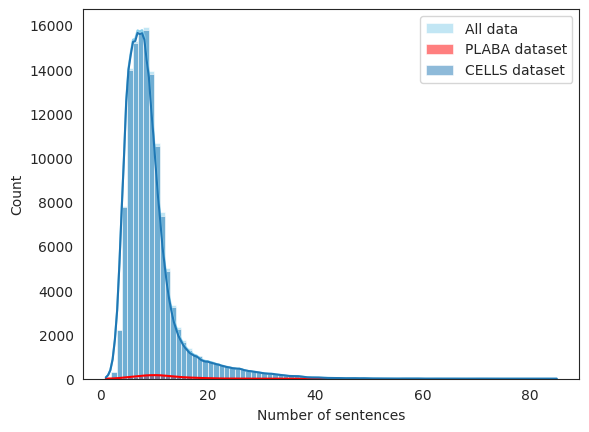

In [ ]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)
sns.set_style("white")

sns.histplot(data=final_df['COUNTS'], color="skyblue", label="All data", kde=True, binwidth=1)
sns.histplot(data=nature_df['COUNTS'], color="red", label="PLABA dataset", kde=True, binwidth=1)
hist = sns.histplot(data=pls_retrieval_df['COUNTS'], label="CELLS dataset", kde=True, binwidth=1)
hist.set_xlabel("Number of sentences")

plt.legend()
# in the next version of the distplot function, one would have to write:
# sns.distplot(data=df, x="sepal_length", kind='hist') # note that 'kind' is 'hist' by default
plt.show()

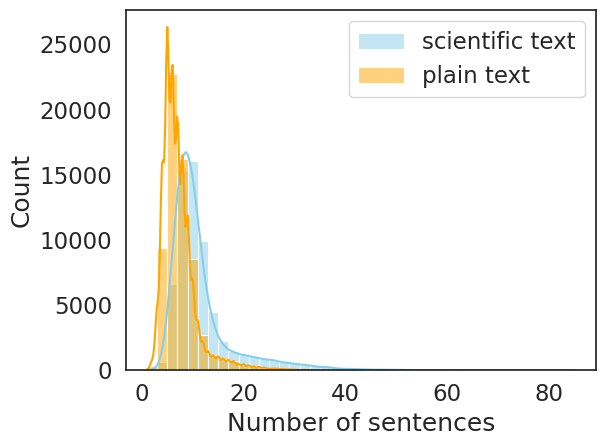

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")

compl_data = final_df[final_df['CATEGORY']==0]['COUNTS']
simple_data = final_df[final_df['CATEGORY']==1]['COUNTS']
sns.histplot(data=compl_data, color="skyblue", label="scientific text", kde=True, binwidth=2)
hist = sns.histplot(data=simple_data, color="orange", label="plain text", kde=True, binwidth=2)
hist.set_xlabel("Number of sentences")
#hist.set_title("All data", fontdict={'size': 15})

plt.legend()
plt.tight_layout()
plt.savefig("gdrive/MyDrive/thesis_data/alldata_sent_distribution.png")
plt.show()

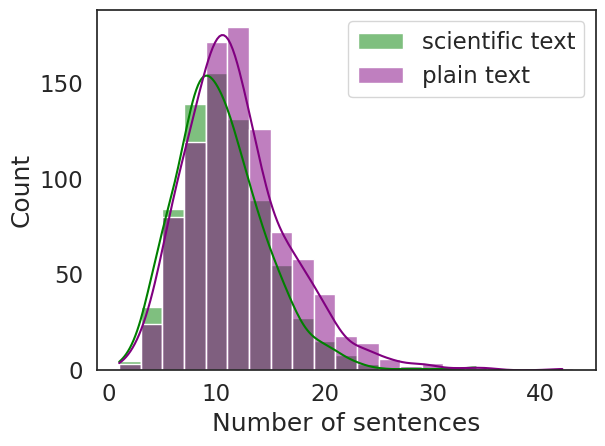

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")

compl_data = nature_df[nature_df['CATEGORY']==0]['COUNTS']
simple_data = nature_df[nature_df['CATEGORY']==1]['COUNTS']
sns.histplot(data=compl_data, color="green", label="scientific text", kde=True, binwidth=2)
hist = sns.histplot(data=simple_data, color="purple", label="plain text", kde=True, binwidth=2)
hist.set_xlabel("Number of sentences")
#hist.set_title("CELLS dataset", fontdict={'size': 15})

plt.legend()

plt.tight_layout()
plt.savefig("gdrive/MyDrive/thesis_data/cells_sent_distribution.png")
plt.show()

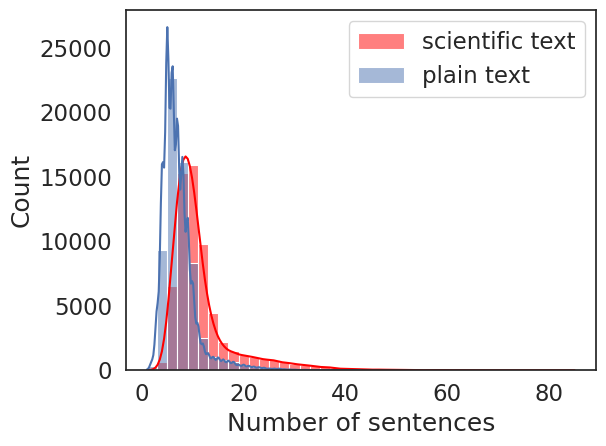

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")

compl_data = pls_retrieval_df[pls_retrieval_df['CATEGORY']==0]['COUNTS']
simple_data = pls_retrieval_df[pls_retrieval_df['CATEGORY']==1]['COUNTS']
sns.histplot(data=compl_data, color="red", label="scientific text", kde=True, binwidth=2)
hist = sns.histplot(data=simple_data, label="plain text", kde=True, binwidth=2)
hist.set_xlabel("Number of sentences")
#hist.set_title("PLABA data", fontdict={'size': 15})

plt.legend()

plt.tight_layout()
plt.savefig("gdrive/MyDrive/thesis_data/plaba_sent_distribution.png")
plt.show()